### Import libraries

In [1]:
import numpy as np
import pandas as pd
import re
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Embedding, Dropout, Input, Concatenate, Lambda, Bidirectional
from keras.preprocessing.text import Tokenizer
import keras.backend as K
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model

import gensim.downloader as api
# Load the pre-trained GloVe embeddings
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Read and save train_csv, test_csv and QA_csv in `train_df`, `test_df` and `qa_df` respectively

In [3]:
train_csv_path = '/content/drive/MyDrive/Colab Notebooks/CA4/train.csv'
test_csv_path = '/content/drive/MyDrive/Colab Notebooks/CA4/test.csv'
qa_csv_path = '/content/drive/MyDrive/Colab Notebooks/CA4/QA_data.csv'

# Load the CSV files into Pandas dataframes
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
qa_df = pd.read_csv(qa_csv_path, encoding='iso-8859-1')

### Analysis created dataframes

In [4]:
print(f'train_df count: {len(train_df)}')
print(f'test_df count: {len(test_df)}')
print(f'qa_df count: {len(qa_df)}')

train_df count: 5452
test_df count: 500
qa_df count: 500


In [5]:
train_df.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [6]:
print(f'Unique amounts of label-coarse columns = {train_df["label-coarse"].unique()}')
print(f'Unique amounts of label-fine   columns = {train_df["label-fine"].unique()}')

Unique amounts of label-coarse columns = [0 1 2 3 4 5]
Unique amounts of label-fine   columns = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [7]:
test_df.head()

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?
3,0,7,What is an atom ?
4,4,8,When did Hawaii become a state ?


In [8]:
qa_df.head()

,label-coarse,label-fine,text,answer
0,4,40,How far is it from Denver to Aspen ?,220 miles
1,5,21,"What county is Modesto , California in ?",Stanislaus
2,3,12,Who was Galileo ?,Italian scientist
3,0,7,What is an atom ?,smallest particle of an element
4,4,8,When did Hawaii become a state ?,1959


## 3.2: Dataset

In [9]:
main_classes = {
    0: 'ABBR',
    1: 'ENTY',
    2: 'DESC',
    3: 'HUM',
    4: 'LOC',
    5: 'NUM'
}

sub_classes = {
    'ABBR': ['abb', 'exp'],
    'ENTY': ['animal', 'body', 'color', 'cremat', 'currency', 'dismed', 'event', 'food', 'instru', 'lang', 'letter', 'other', 'plant', 'product', 'religion', 'sport', 'substance', 'symbol', 'techmeth', 'termeq', 'veh', 'word'],
    'DESC': ['desc', 'def', 'manner', 'reason'],
    'HUM': ['desc', 'gr', 'ind', 'title'],
    'LOC': ['city', 'country', 'mount', 'other', 'state'],
    'NUM': ['code', 'count', 'date', 'dist', 'money', 'ord', 'other', 'period', 'perc', 'speed', 'temp', 'volsize', 'weight']
}

def clean_string(string):
    # Remove special characters and punctuation symbols (excluding '?')
    string = re.sub(r'[^\w\s\?]', '', string)
    # Transform all words to lowercase
    string = string.lower()
    return string

### Load data

In [10]:
# Extract the questions and their corresponding labels from the dataframes
train_label_coarse = []
train_label_fine = []
train_questions = []

test_label_coarse = []
test_label_fine = []
test_questions = []

qa_label_coarse = []
qa_label_fine = []
qa_questions = []
qa_answer = []

for i, row in train_df.iterrows():
    label_coarse, label_fine, question = row['label-coarse'], row['label-fine'], row['text']
    train_questions.append(clean_string(question))
    train_label_coarse.append(label_coarse)
    train_label_fine.append(label_fine)

for i, row in test_df.iterrows():
    label_coarse, label_fine, question = row['label-coarse'], row['label-fine'], row['text']
    test_questions.append(clean_string(question))
    test_label_coarse.append(label_coarse)
    test_label_fine.append(label_fine)

for i, row in qa_df.iterrows():
    label_coarse, label_fine, question, answer = row['label-coarse'], row['label-fine'], row['text'], row['answer']
    qa_questions.append(clean_string(question))
    qa_answer.append(answer)
    qa_label_coarse.append(label_coarse)
    qa_label_fine.append(label_fine)

In [11]:
sample_num = 10
print(f'A sample of train set: {train_questions[sample_num]}\n train_label_coarse: {train_label_coarse[sample_num]}\n train_label_fine: {train_label_fine[sample_num]}')

A sample of train set: when was ozzy osbourne born ?
 train_label_coarse: 4
 train_label_fine: 8


## 3.1: Embedding

In [12]:
# Define the maximum length of the input sequence
max_length = 50

# Define a function to convert a sentence to a matrix of GloVe embeddings
def sentence_to_embeddings(sentence, max_length):
    # Split the sentence into words
    words = sentence.split()
    
    # pad the sequence to the maximum length
    words = words[:max_length] + [''] * (max_length - len(words))
    
    # Convert each word to its corresponding embedding
    embeddings = [glove_model[word] if word in glove_model else np.zeros(glove_model.vector_size) for word in words]
    
    return embeddings

embedded_train_questions = np.zeros((len(train_questions), max_length, glove_model.vector_size))
for i, question in enumerate(train_questions):
    embedded_train_questions[i, :, :] = sentence_to_embeddings(question, max_length)

embedded_test_questions = np.zeros((len(test_questions), max_length, glove_model.vector_size))
for i, question in enumerate(test_questions):
    embedded_test_questions[i, :, :] = sentence_to_embeddings(question, max_length)

embedded_qa_questions = np.zeros((len(qa_questions), max_length, glove_model.vector_size))
for i, question in enumerate(qa_questions):
    embedded_qa_questions[i, :, :] = sentence_to_embeddings(question, max_length)

embedded_qa_answers = np.zeros((len(qa_answer), max_length, glove_model.vector_size))
for i, question in enumerate(qa_answer):
    embedded_qa_answers[i, :, :] = sentence_to_embeddings(question, max_length)

print(f'Size of embedded_train_questions: {np.array(embedded_train_questions).shape}')

Size of embedded_train_questions: (5452, 50, 300)


In [13]:
input_size = glove_model.vector_size
output_size_main = len(main_classes)
output_size_sub = len(set(train_label_fine))

### Convert labels to one-hot encoding forms

In [14]:
train_label_coarse = to_categorical(train_label_coarse, output_size_main)
train_label_fine = to_categorical(train_label_fine, output_size_sub)
test_label_coarse = to_categorical(test_label_coarse, output_size_main)
test_label_fine = to_categorical(test_label_fine, output_size_sub)
qa_label_coarse = to_categorical(qa_label_coarse, output_size_main)
qa_label_fine = to_categorical(qa_label_fine, output_size_sub)

### Metrics

In [15]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def accuracy(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total = K.sum(K.round(K.clip(y_true + (1 - y_true), 0, 1)))
    accuracy = (true_positives + true_negatives) / total
    return accuracy

In [16]:
def plot_accuracy(history, model_type, class_type, ax=None):
    if model_type == 2:
        ax.plot(history.history[f'{class_type}accuracy'])
        ax.plot(history.history[f'val_{class_type}accuracy'])
        ax.set_title(f'{class_type} Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')
    else:
        ax.plot(history.history['accuracy'])
        ax.plot(history.history['val_accuracy'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

def plot_loss(history, model_type, class_type, ax=None):
    if model_type == 2:
        ax.plot(history.history[f'{class_type}loss'])
        ax.plot(history.history[f'val_{class_type}loss'])
        ax.set_title(f'{class_type} Model Loss')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')
    else:
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title('Model Loss')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')

def plot_precision(history, model_type, class_type, ax=None):
    if model_type == 2:
        ax.plot(history.history[f'{class_type}precision'])
        ax.plot(history.history[f'val_{class_type}precision'])
        ax.set_title(f'{class_type} Precision')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')
    else:
        ax.plot(history.history['precision'])
        ax.plot(history.history['val_precision'])
        ax.set_title('Precision')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')

def plot_recall(history, model_type, class_type, ax=None):
    if model_type == 2:
        ax.plot(history.history[f'{class_type}recall'])
        ax.plot(history.history[f'val_{class_type}recall'])
        ax.set_title(f'{class_type} Recall')
        ax.set_ylabel('Recall')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')
    else:
        ax.plot(history.history['recall'])
        ax.plot(history.history['val_recall'])
        ax.set_title('Recall')
        ax.set_ylabel('Recall')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')

def plot_f1_score(history, model_type, class_type, ax=None):
    if model_type == 2:
        ax.plot(history.history[f'{class_type}f1_score'])
        ax.plot(history.history[f'val_{class_type}f1_score'])
        ax.set_title(f'{class_type} F1 Score')
        ax.set_ylabel('F1 Score')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')
    else:
        ax.plot(history.history['f1_score'])
        ax.plot(history.history['val_f1_score'])
        ax.set_title('F1 Score')
        ax.set_ylabel('F1 Score')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='upper left')

In [17]:
def plot__metrics(history, title, model_type, class_type=''):
    num_rows = 3
    num_cols = 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))

    plot_accuracy(history, model_type, class_type, ax=axes[0, 0])
    plot_loss(history, model_type, class_type, ax=axes[0, 1])
    plot_precision(history, model_type, class_type, ax=axes[1, 0])
    plot_recall(history, model_type, class_type, ax=axes[1, 1])
    plot_f1_score(history, model_type, class_type, ax=axes[2, 0])

    fig.suptitle(title, fontsize=20)

    plt.tight_layout()

    plt.show()

In [18]:
def show_confusion_matrix_first_model(model, embedded_test_questions, test_label_coarse):
    y_pred_main = np.argmax(model.predict(embedded_test_questions), axis=1)
    y_true_main = np.argmax(test_label_coarse, axis=1)
    conf_mat_main = confusion_matrix(y_true_main, y_pred_main)

    print('Confusion matrix for main classes classification:')
    print(conf_mat_main)

In [19]:
def show_confusion_matrix_second_model(model):
    y_pred_main = np.argmax(model.predict(embedded_test_questions)[0], axis=1)
    y_true_main = np.argmax(test_label_coarse, axis=1)
    conf_mat_main = confusion_matrix(y_true_main, y_pred_main)

    y_pred_sub = np.argmax(model.predict(embedded_test_questions)[1], axis=1)
    y_true_sub = np.argmax(test_label_fine, axis=1)
    conf_mat_sub = confusion_matrix(y_true_sub, y_pred_sub)

    print('Confusion matrix for main classes classification:')
    print(conf_mat_main)

    print('Confusion matrix for sub classes classification:')
    print(conf_mat_sub)

## 3.3.1: First Model

### Create first model with 100 hidden states

In [ ]:
hidden_size = 100

model1 = Sequential()
model1.add(LSTM(hidden_size,
                input_shape=(max_length, glove_model.vector_size)))
model1.add(Dropout(0.5))
model1.add(Dense(output_size_main, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 161,006
Trainable params: 161,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=[accuracy, precision, recall, f1_score])

history1 = model1.fit(np.array(embedded_train_questions), np.array(train_label_coarse), epochs=50, batch_size=16,
           validation_data=(np.array(embedded_test_questions), np.array(test_label_coarse)))

Epoch 1/50
341/341 [==============================] - 13s 11ms/step - loss: 1.4704 - accuracy: 0.8448 - precision: 0.5152 - recall: 0.1092 - f1_score: 0.1727 - val_loss: 1.3027 - val_accuracy: 0.8496 - val_precision: 0.7292 - val_recall: 0.1016 - val_f1_score: 0.1749
Epoch 2/50
341/341 [==============================] - 3s 7ms/step - loss: 1.1720 - accuracy: 0.8624 - precision: 0.7276 - recall: 0.2854 - f1_score: 0.3939 - val_loss: 0.9726 - val_accuracy: 0.8880 - val_precision: 0.7634 - val_recall: 0.4648 - val_f1_score: 0.5737
Epoch 3/50
341/341 [==============================] - 2s 6ms/step - loss: 0.9568 - accuracy: 0.8839 - precision: 0.7390 - recall: 0.4704 - f1_score: 0.5656 - val_loss: 0.8223 - val_accuracy: 0.9160 - val_precision: 0.7916 - val_recall: 0.6719 - val_f1_score: 0.7251
Epoch 4/50
341/341 [==============================] - 2s 6ms/step - loss: 0.8505 - accuracy: 0.9021 - precision: 0.7474 - recall: 0.6241 - f1_score: 0.6773 - val_loss: 0.7713 - val_accuracy: 0.9170 - 

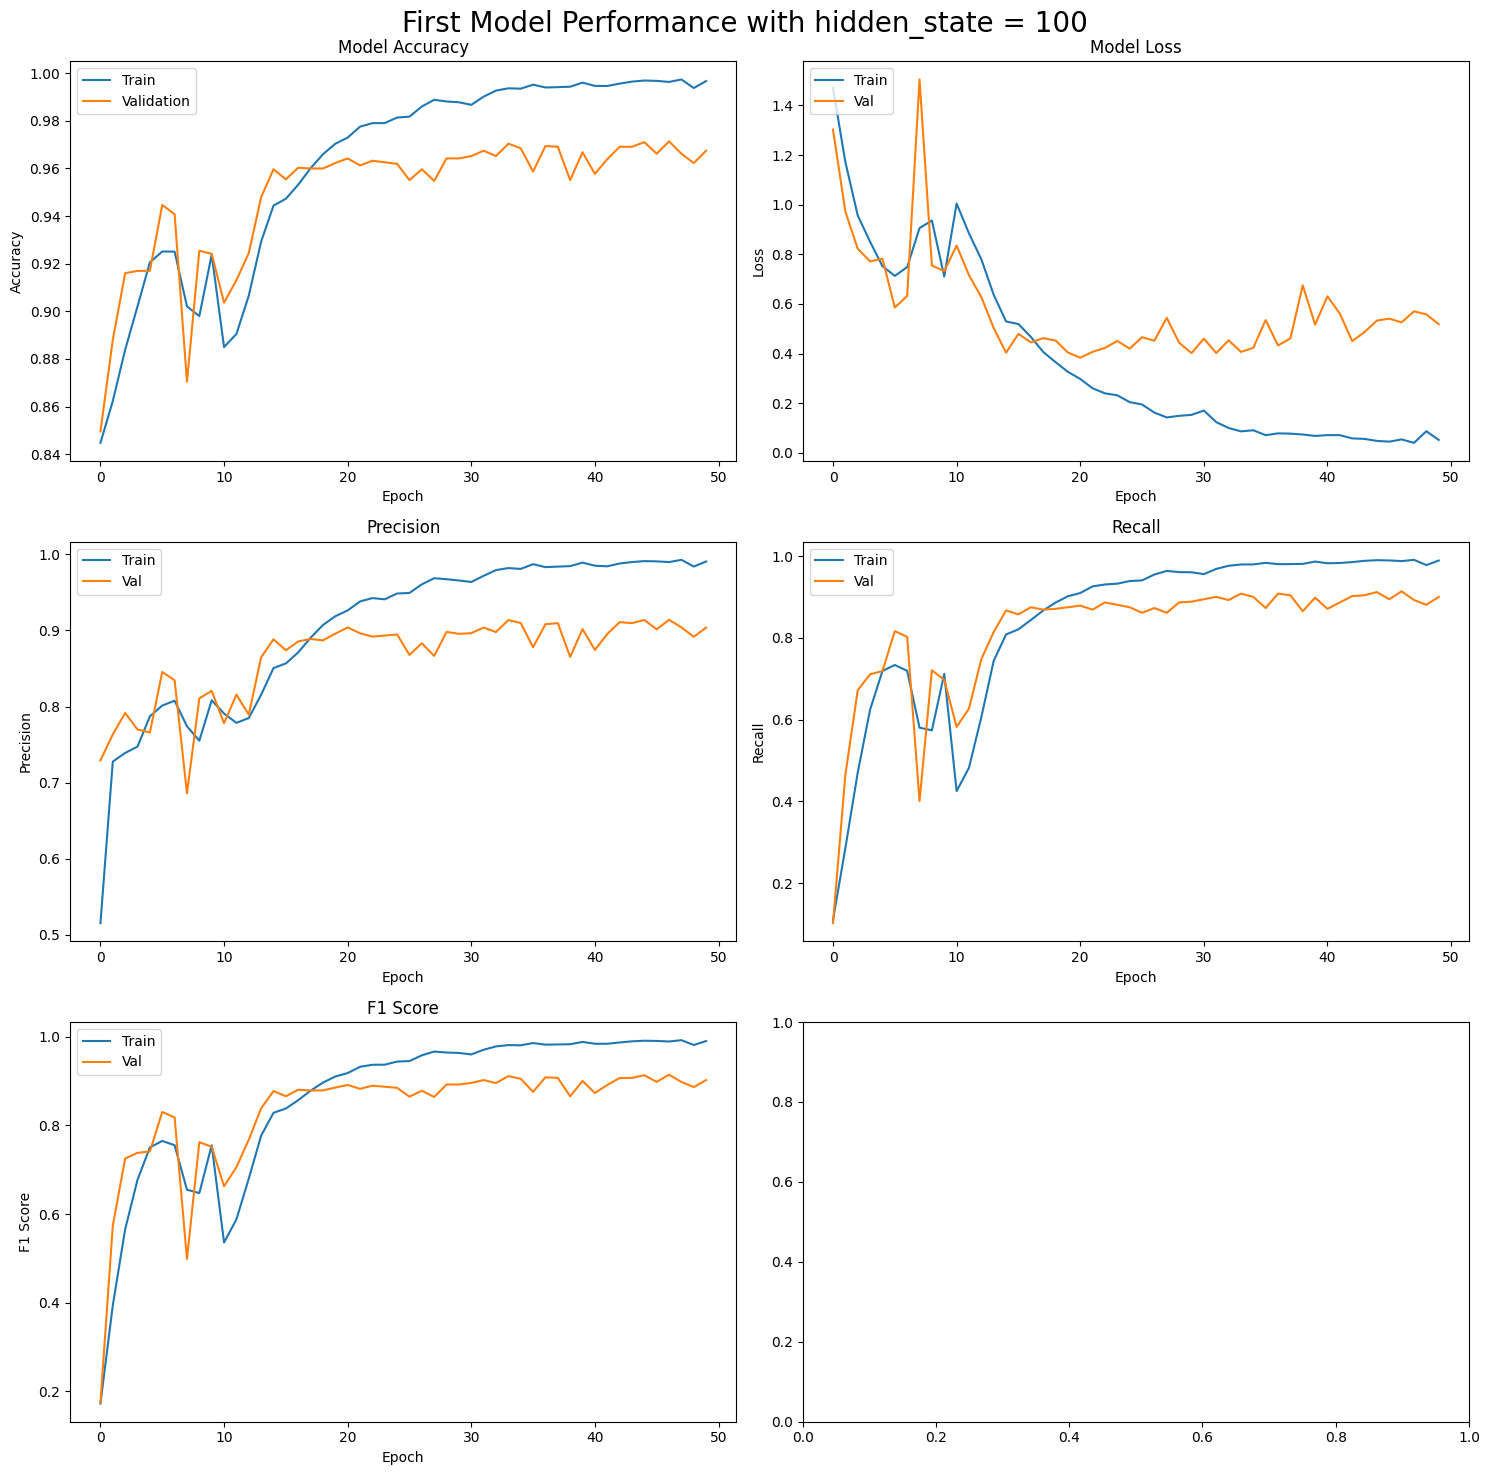

In [ ]:
plot__metrics(history1, 'First Model Performance with hidden_state = 100', model_type=1)

In [ ]:
show_confusion_matrix_first_model(model1, embedded_test_questions, test_label_coarse)

16/16 [==============================] - 0s 5ms/step
Confusion matrix for main classes classification:
[[128   6   3   0   0   1]
 [  6  76   0   4   1   7]
 [  3   0   6   0   0   0]
 [  0   4   0  60   0   1]
 [  6   0   0   0 104   3]
 [  1   5   0   0   0  75]]


### Create first model with 25 hidden states

In [ ]:
hidden_size = 25

model2 = Sequential()
model2.add(LSTM(hidden_size,
                input_shape=(max_length, glove_model.vector_size)))
model2.add(Dropout(0.5))
model2.add(Dense(output_size_main, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 25)                32600     
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 156       
                                                                 
Total params: 32,756
Trainable params: 32,756
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=[accuracy, precision, recall, f1_score])

history2 = model2.fit(np.array(embedded_train_questions), np.array(train_label_coarse), epochs=50, batch_size=16,
           validation_data=(np.array(embedded_test_questions), np.array(test_label_coarse)))

Epoch 1/50
341/341 [==============================] - 6s 10ms/step - loss: 1.6482 - accuracy: 0.8353 - precision: 0.1833 - recall: 0.0253 - f1_score: 0.0427 - val_loss: 1.5215 - val_accuracy: 0.8457 - val_precision: 0.6562 - val_recall: 0.0957 - val_f1_score: 0.1634
Epoch 2/50
341/341 [==============================] - 4s 12ms/step - loss: 1.2742 - accuracy: 0.8592 - precision: 0.7488 - recall: 0.2324 - f1_score: 0.3416 - val_loss: 1.1883 - val_accuracy: 0.8646 - val_precision: 0.9148 - val_recall: 0.1934 - val_f1_score: 0.3064
Epoch 3/50
341/341 [==============================] - 3s 7ms/step - loss: 1.0783 - accuracy: 0.8721 - precision: 0.7535 - recall: 0.3498 - f1_score: 0.4651 - val_loss: 0.9391 - val_accuracy: 0.8656 - val_precision: 0.7837 - val_recall: 0.2344 - val_f1_score: 0.3510
Epoch 4/50
341/341 [==============================] - 2s 6ms/step - loss: 0.9102 - accuracy: 0.8868 - precision: 0.7595 - recall: 0.4687 - f1_score: 0.5730 - val_loss: 0.7876 - val_accuracy: 0.9215 - 

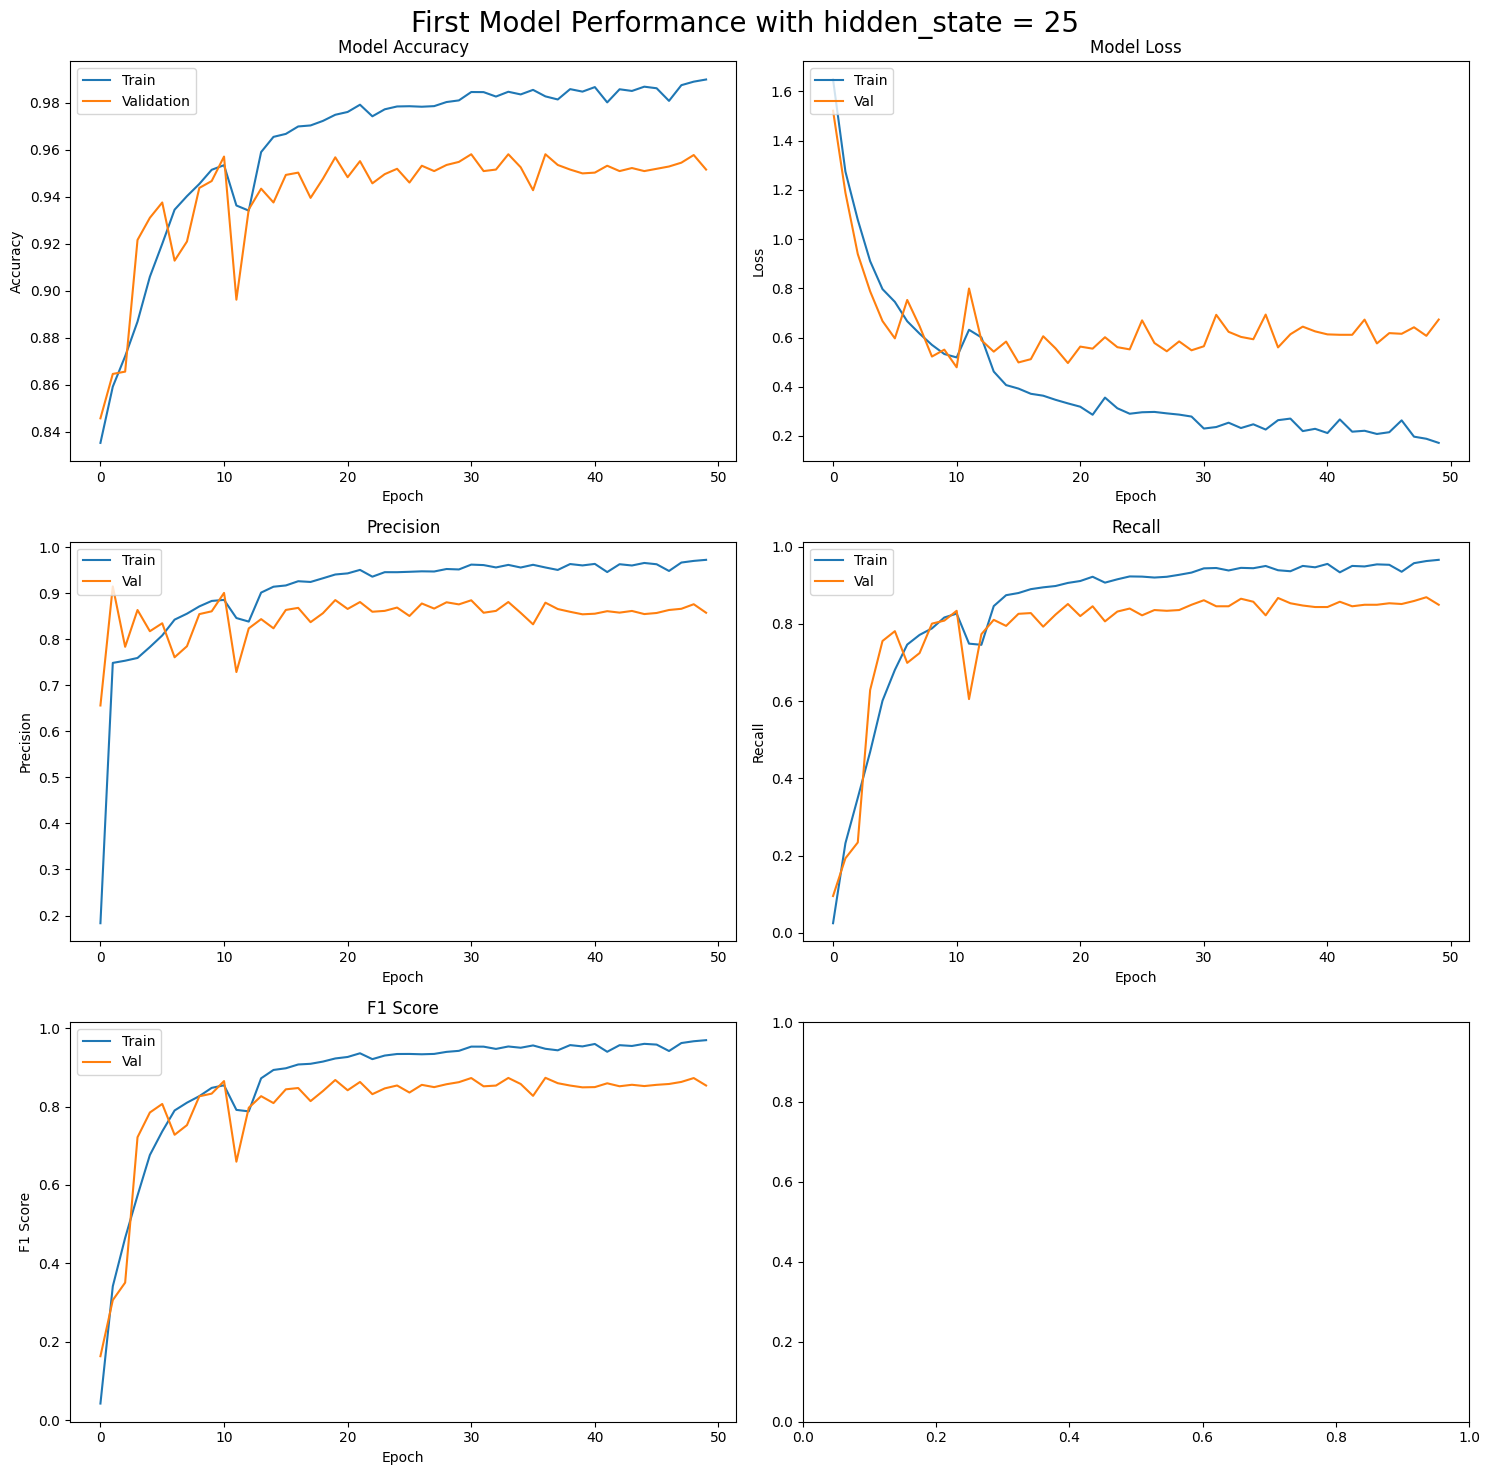

In [ ]:
plot__metrics(history2, 'First Model Performance with hidden_state = 25', model_type=1)

In [ ]:
show_confusion_matrix_first_model(model2, embedded_test_questions, test_label_coarse)

16/16 [==============================] - 1s 5ms/step
Confusion matrix for main classes classification:
[[130   4   3   0   1   0]
 [ 20  62   2   8   1   1]
 [  3   0   6   0   0   0]
 [  0   2   0  62   0   1]
 [ 13   1   0   0  96   3]
 [  0   5   2   0   1  73]]


## 3.3.2: Second Model

### Create second model with 100 hidden states

In [20]:
hidden_size = 100

input_shape = (max_length, glove_model.vector_size)
input_layer = Input(shape=input_shape, name='input_layer')

lstm_layer = LSTM(units=hidden_size, return_sequences=True, name='lstm_layer')(input_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# Define the output layers for the main classification and sub-classification
output_coarse = Dense(units=output_size_main, activation='softmax', name='main_class')(lstm_layer[:, -2, :])
output_fine = Dense(units=output_size_sub, activation='softmax', name='sub_class')(lstm_layer[:, -1, :])

model3 = Model(inputs=input_layer, outputs=[output_coarse, output_fine])

model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 50, 300)]    0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 50, 100)      160400      ['input_layer[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 50, 100)      0           ['lstm_layer[0][0]']             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 100)         0           ['dropout[0][0]']                
 ingOpLambda)                                                                                 

In [21]:
model3.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam',
            metrics=[accuracy, precision, recall, f1_score])

history3 = model3.fit(np.array(embedded_train_questions), 
                    [np.array(train_label_coarse), np.array(train_label_fine)], 
                    epochs=50, batch_size=16,
                    validation_data=(np.array(embedded_test_questions), 
                                    [np.array(test_label_coarse), np.array(test_label_fine)]))

Epoch 1/50
341/341 [==============================] - 14s 14ms/step - loss: 4.8959 - main_class_loss: 1.7107 - sub_class_loss: 3.1852 - main_class_accuracy: 0.8328 - main_class_precision: 0.0176 - main_class_recall: 0.0016 - main_class_f1_score: 0.0029 - sub_class_accuracy: 0.9787 - sub_class_precision: 0.0029 - sub_class_recall: 1.8328e-04 - sub_class_f1_score: 3.4501e-04 - val_loss: 4.9309 - val_main_class_loss: 1.6934 - val_sub_class_loss: 3.2375 - val_main_class_accuracy: 0.8333 - val_main_class_precision: 0.0000e+00 - val_main_class_recall: 0.0000e+00 - val_main_class_f1_score: 0.0000e+00 - val_sub_class_accuracy: 0.9787 - val_sub_class_precision: 0.0000e+00 - val_sub_class_recall: 0.0000e+00 - val_sub_class_f1_score: 0.0000e+00
Epoch 2/50
341/341 [==============================] - 3s 8ms/step - loss: 4.7750 - main_class_loss: 1.6769 - sub_class_loss: 3.0981 - main_class_accuracy: 0.8333 - main_class_precision: 0.0000e+00 - main_class_recall: 0.0000e+00 - main_class_f1_score: 0.00

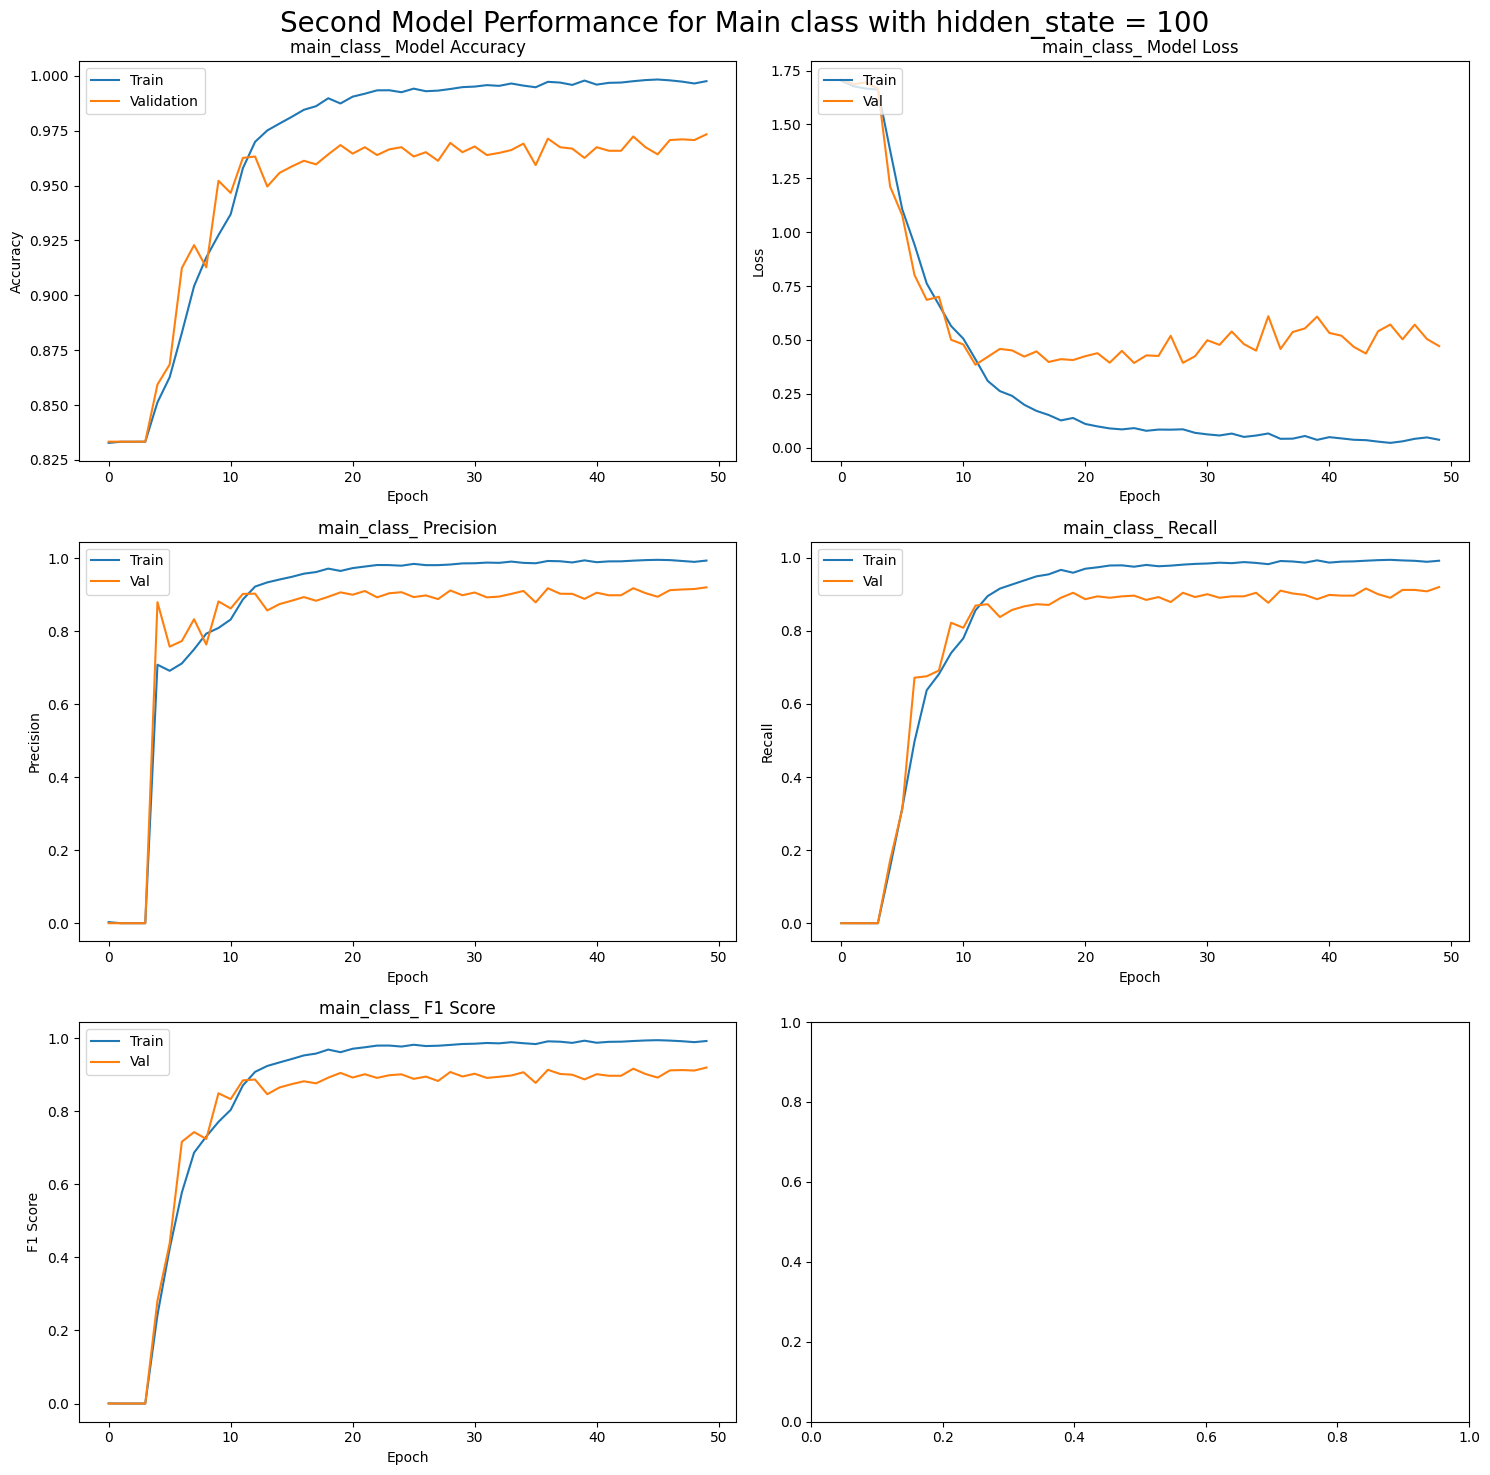

In [23]:
plot__metrics(history3, 'Second Model Performance for Main class with hidden_state = 100', model_type=2, class_type='main_class_')

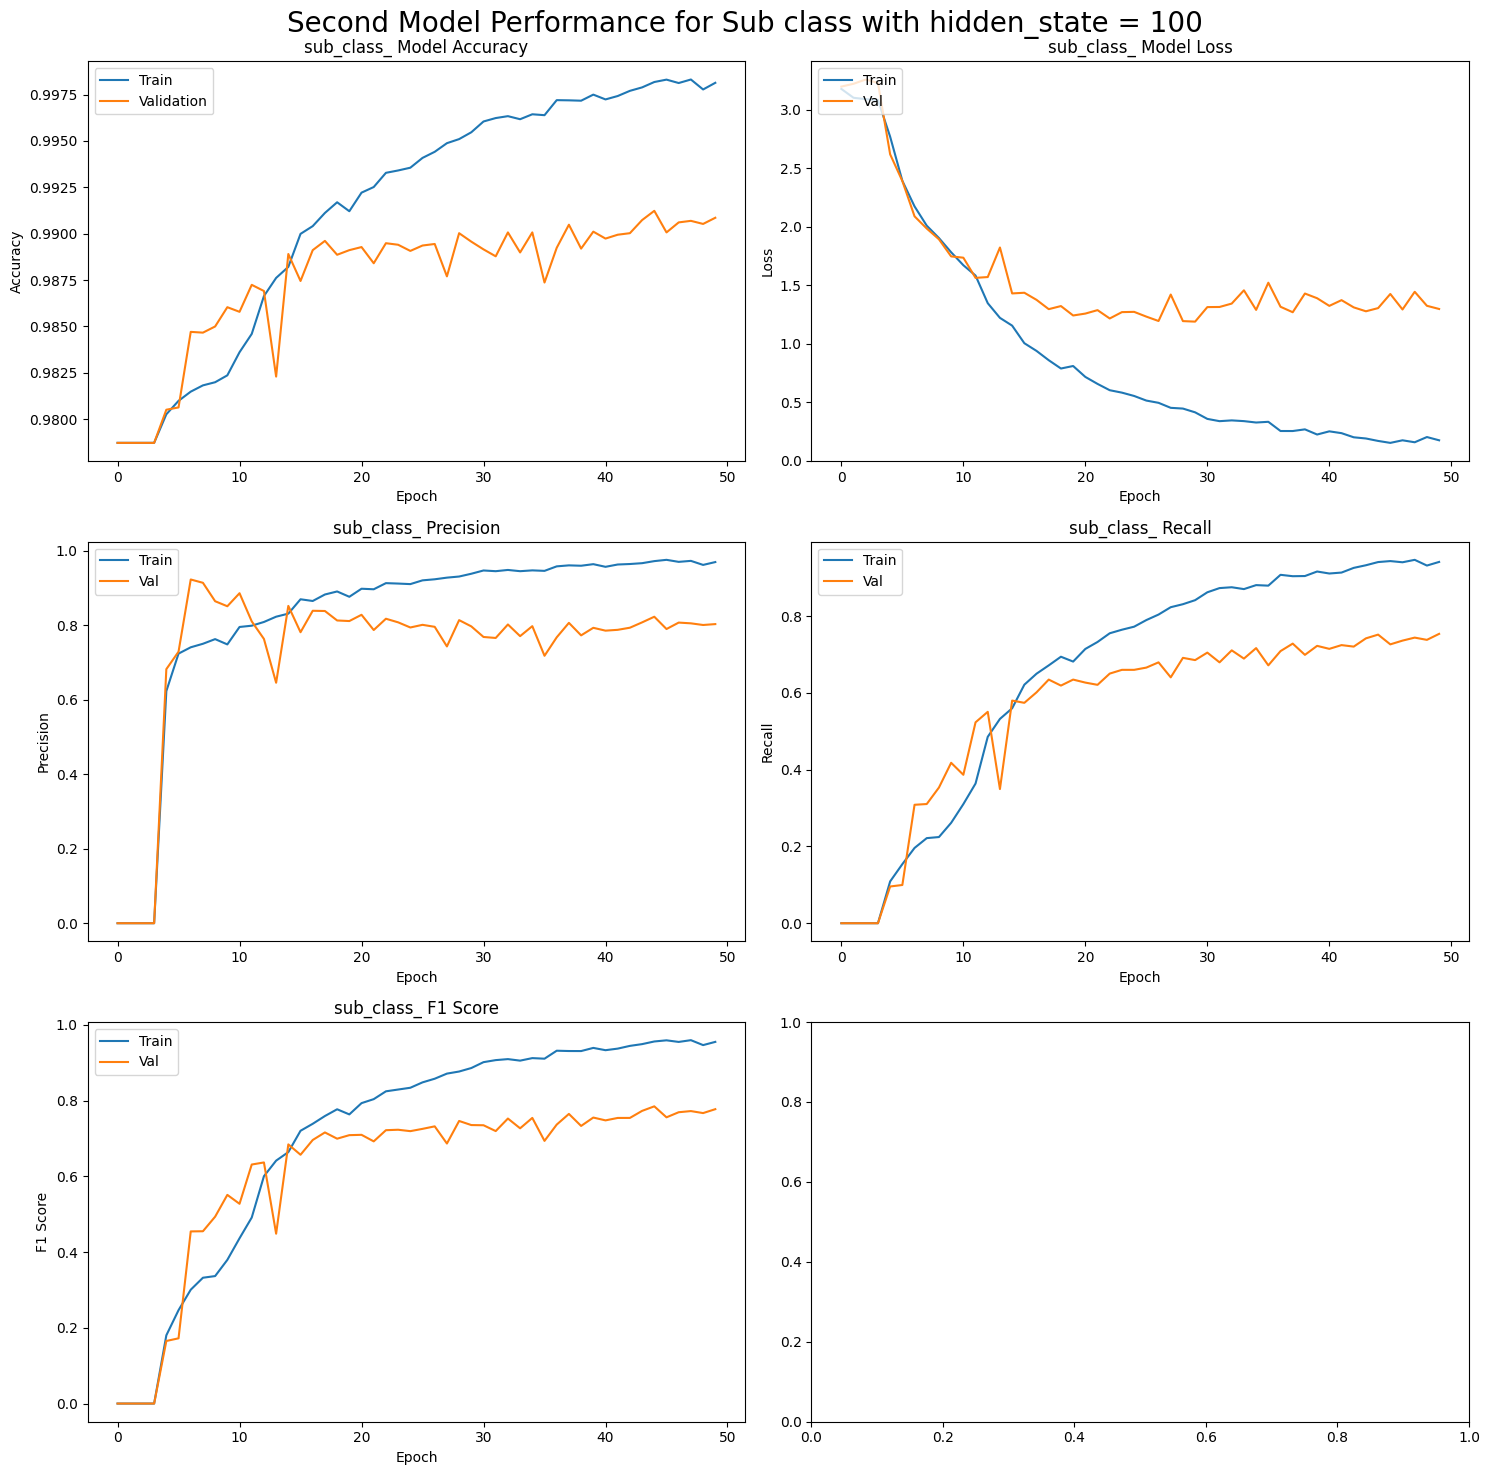

In [24]:
plot__metrics(history3, 'Second Model Performance for Sub class with hidden_state = 100', model_type=2, class_type='sub_class_')

In [25]:
show_confusion_matrix_second_model(model3)

16/16 [==============================] - 0s 5ms/step
Confusion matrix for main classes classification:
[[133   3   1   0   1   0]
 [  6  78   0   3   3   4]
 [  2   0   7   0   0   0]
 [  0   3   0  61   0   1]
 [  4   1   0   0 108   0]
 [  1   6   0   1   1  72]]
Confusion matrix for sub classes classification:
[[ 2  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  1  0  0]]


### Create second model with 25 hidden states

In [ ]:
hidden_size = 25

input_shape = (max_length, glove_model.vector_size)
input_layer = Input(shape=input_shape, name='input_layer')

lstm_layer = LSTM(units=hidden_size, return_sequences=True, name='lstm_layer')(input_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# Define the output layers for the main classification and sub-classification
output_coarse = Dense(units=output_size_main, activation='softmax', name='main_class')(lstm_layer[:, -2, :])
output_fine = Dense(units=output_size_sub, activation='softmax', name='sub_class')(lstm_layer[:, -1, :])

model4 = Model(inputs=input_layer, outputs=[output_coarse, output_fine])

model4.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 50, 300)]    0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 50, 25)       32600       ['input_layer[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 50, 25)       0           ['lstm_layer[0][0]']             
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 25)          0           ['dropout[0][0]']                
 ingOpLambda)                                                                               

In [ ]:
# Use two loss functions for the two outputs 
model4.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], 
            optimizer='adam',
            metrics=[accuracy, precision, recall, f1_score])

# Train the model 
history4 = model4.fit(np.array(embedded_train_questions), 
                    [np.array(train_label_coarse), np.array(train_label_fine)], 
                    epochs=50, batch_size=16,
                    validation_data=(np.array(embedded_test_questions), 
                                    [np.array(test_label_coarse), np.array(test_label_fine)]))

Epoch 1/50
341/341 [==============================] - 13s 11ms/step - loss: 5.0252 - main_class_loss: 1.7323 - sub_class_loss: 3.2929 - main_class_accuracy: 0.8328 - main_class_precision: 0.0308 - main_class_recall: 0.0022 - main_class_f1_score: 0.0041 - sub_class_accuracy: 0.9787 - sub_class_precision: 0.0000e+00 - sub_class_recall: 0.0000e+00 - sub_class_f1_score: 0.0000e+00 - val_loss: 4.8302 - val_main_class_loss: 1.6666 - val_sub_class_loss: 3.1636 - val_main_class_accuracy: 0.8333 - val_main_class_precision: 0.0000e+00 - val_main_class_recall: 0.0000e+00 - val_main_class_f1_score: 0.0000e+00 - val_sub_class_accuracy: 0.9787 - val_sub_class_precision: 0.0000e+00 - val_sub_class_recall: 0.0000e+00 - val_sub_class_f1_score: 0.0000e+00
Epoch 2/50
341/341 [==============================] - 3s 9ms/step - loss: 4.6224 - main_class_loss: 1.5861 - sub_class_loss: 3.0363 - main_class_accuracy: 0.8346 - main_class_precision: 0.3931 - main_class_recall: 0.0552 - main_class_f1_score: 0.0934 -

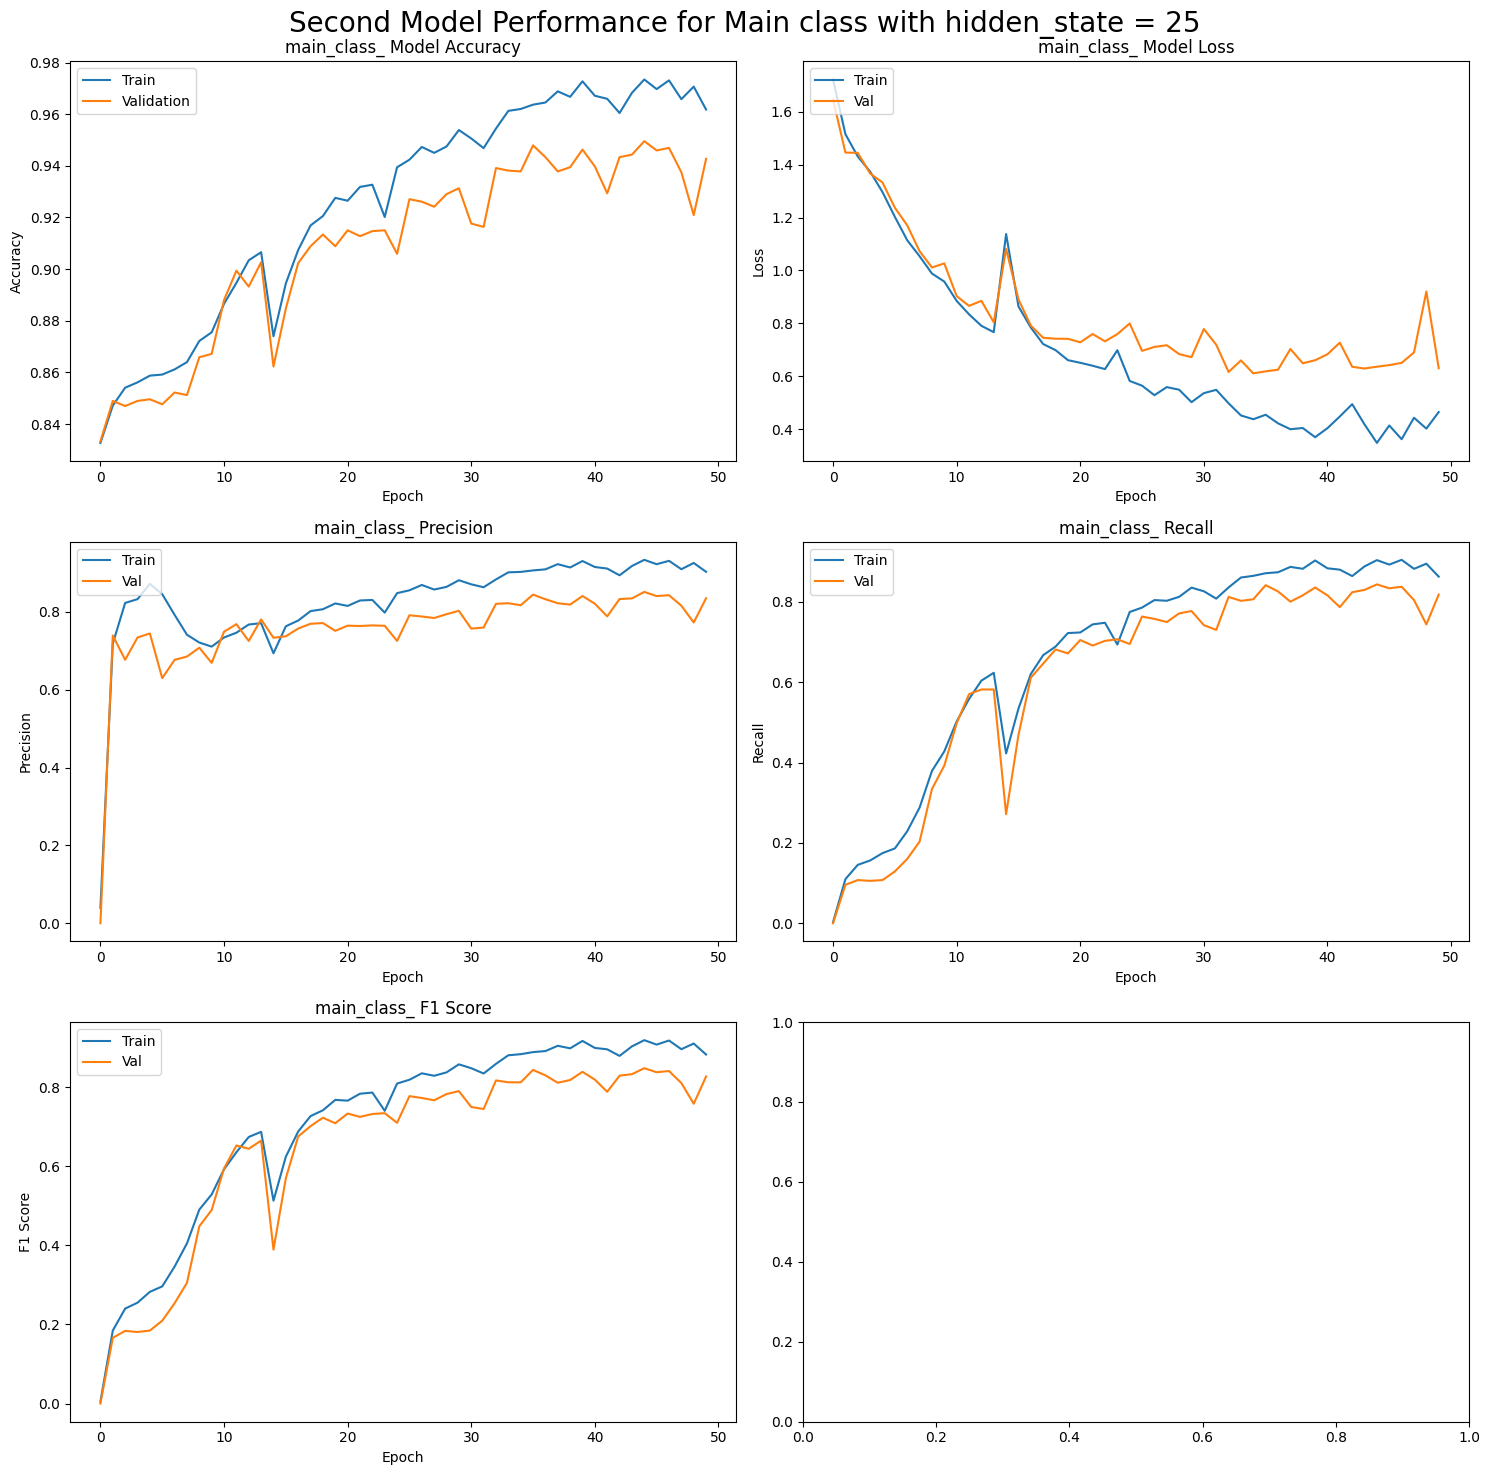

In [ ]:
plot__metrics(history4, 'Second Model Performance for Main class with hidden_state = 25', model_type=2, class_type='main_class_')

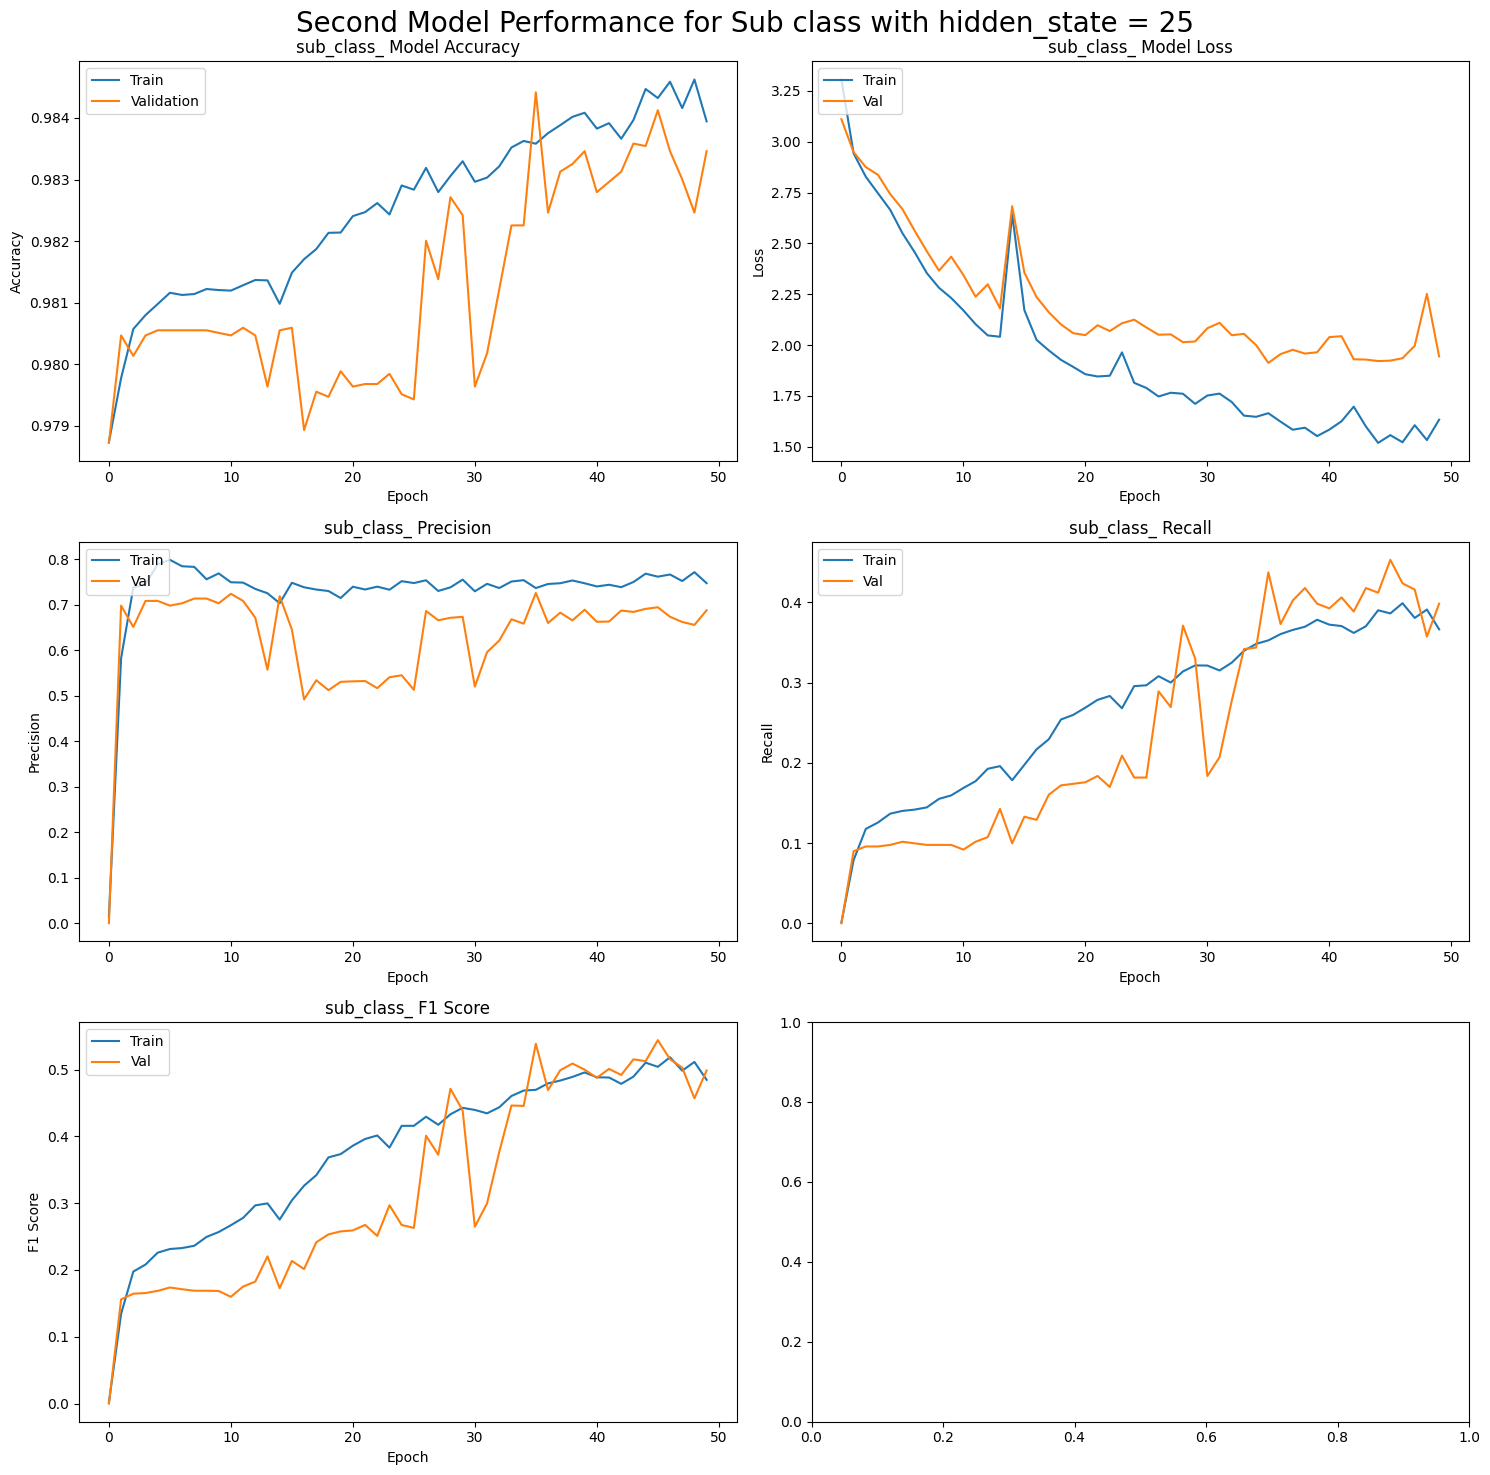

In [ ]:
plot__metrics(history4, 'Second Model Performance for Sub class with hidden_state = 25', model_type=2, class_type='sub_class_')

In [ ]:
show_confusion_matrix_second_model(model4)

16/16 [==============================] - 0s 3ms/step
Confusion matrix for main classes classification:
[[119  16   0   0   1   2]
 [ 14  66   5   4   1   4]
 [  2   0   7   0   0   0]
 [  0   4   0  60   0   1]
 [  8   0   0   2  96   7]
 [  5   5   0   0   8  63]]
Confusion matrix for sub classes classification:
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 3.4: Prototype Responder

In [66]:
def generate_answer(question, model):
  
    question_embeddings = sentence_to_embeddings(question, max_length)

    # Generate the answer using the BLSTM network
    answer_embeddings = model.predict(np.array([question_embeddings]))
    
    return glove_model.similar_by_vector(answer_embeddings[0][0], topn=1)[0][0]

In [64]:
hidden_size = 100

input_shape = (max_length, glove_model.vector_size)
input_layer = Input(shape=input_shape, name='input_layer')

# Feed the remaining LSTM hidden states as input to the BLSTM
blstm_layer = Bidirectional(LSTM(units=hidden_size, return_sequences=True, name='blstm_layer'), weights=model3.layers[1].get_weights())(input_layer)
blstm_layer = Dropout(0.5)(blstm_layer)

dense_layer = Dense(units=glove_model.vector_size, name='dense_layer')(blstm_layer) 

model_response = Model(inputs=input_layer, outputs=dense_layer)

model_response.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 300)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 200)          320800    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 50, 200)           0         
                                                                 
 dense_layer (Dense)         (None, 50, 300)           60300     
                                                                 
Total params: 381,100
Trainable params: 381,100
Non-trainable params: 0
_________________________________________________________________


In [65]:
model_response.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model_response.fit(np.array(embedded_qa_questions), np.array(embedded_qa_answers), 
                   epochs=50, batch_size=2)

Epoch 1/50
250/250 [==============================] - 5s 7ms/step - loss: 0.0042 - accuracy: 0.0080
Epoch 2/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0038 - accuracy: 0.0050
Epoch 3/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0037 - accuracy: 0.0049
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0036 - accuracy: 0.0056
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0035 - accuracy: 0.0058
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0034 - accuracy: 0.0064
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0033 - accuracy: 0.0064
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 0.0067
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 0.0031 - accuracy: 0.0066
Epoch 10/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0031 - accuracy: 0.0078

In [67]:
generate_answer('How many people speak French?', model_response)

1/1 [==============================] - 1s 615ms/step


'million'

In [68]:
generate_answer('What day is today?', model_response)

1/1 [==============================] - 0s 27ms/step


'week'

In [69]:
generate_answer('Who will win the war?', model_response)

1/1 [==============================] - 0s 29ms/step


'10'

In [70]:
generate_answer('Who is Italian first minister?', model_response)

1/1 [==============================] - 0s 27ms/step


'pink'

In [71]:
generate_answer('When World War II ended?', model_response)

1/1 [==============================] - 0s 32ms/step


'given'

In [72]:
generate_answer('When Gandhi was assassinated?', model_response)

1/1 [==============================] - 0s 29ms/step


'1827'